
#***DATASET : BITCOIN HISTORICAL DATA***  
[Dataset -> Kaggle](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data)

#Contexto
Este dataset contiene información minuto a minuto de la criptomoneda Bitcoin, contiene variables para determinar el valor más alto, el más bajo, valor con el que inicia la medición (00:00 UTC <-Dia) y el valor con el que termina (23:59 UTC <-Dia). Existe una variable Volume que determina cuanto se ha transaccionado de la moneda en una ventana de tiempo.

#Variables

***HECHOS:*** "OPEN" "HIGH" "LOW" "CLOSE" "VOLUME" /
***DESCRIPTORES:*** "TIMESTAMP"

#Objetivo

Analizar la evolución del valor de la criptomoneda BITCOIN en un intervalo de tiempo diario, desde el año 2012 al año 2025, buscando identificar tendencias en el tiempo y evaluar la relación de dias transcurridos con el valor de cierre, mediante un modelo de regresión

Especificos:

-Transformar datos Unix (minutos) -> Dias
-Describir las variables principales OPEN, HIGH, LOW, CLOSE
-Explorar la relación del valor de cierre con los dias transcurridos
-Ajustar un modelo con la finalidad de evaluar si existe alguna tendencia entre paso de tiempo y valor del bitcoin



#Revision del dataset

## HIPOTESIS 

### El tiempo (En días) desde el 1 de enero del año 2012 tiene un efecto significativo sobre el valor de cierre diario de bitcoin, mostrando una tendencia de crecimiento a lo largo del período que se observa.

## Carga de librerias

In [19]:
#Importaciones relevantes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
import seaborn as sns
import os, sys
#modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression


## AJUSTE DE UNIX PARA MINUTO -> DIAS Y VARIABLE T 

In [27]:
# 🔙 Subir una carpeta desde la ubicación actual del notebook
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ruta del archivo original (minutos)
path = os.path.join(parent_dir, "data", "01_raw", "btcusd_1-min_data.csv")

print("📄 Archivo detectado en:", path)

# Verificar existencia
if not os.path.exists(path):
    raise FileNotFoundError(f"❌ No se encontró el archivo en: {path}")

# Detectar tamaño del archivo
file_size_mb = os.path.getsize(path) / (1024**2)
print(f"📦 Tamaño del archivo: {file_size_mb:.2f} MB")

# Crear acumulador de resultados
df_daily_total = []

# Leer todo el archivo por chunks (procesa el dataset completo)
chunk_size = 500_000  # medio millón de filas por bloque (~200 MB aprox)
print("🚀 Procesando dataset completo en bloques...")

for i, chunk in enumerate(pd.read_csv(path, chunksize=chunk_size)):
    print(f"🧩 Procesando bloque {i+1}...")

    # Asegurar conversión de tiempo
    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], unit='s')
    chunk = chunk.set_index('Timestamp')

    # Resample diario (1D)
    df_daily = chunk.resample('1D').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    df_daily_total.append(df_daily)

# Unir todos los bloques diarios
print("🧮 Combinando resultados...")
df_daily_full = pd.concat(df_daily_total).sort_index()

# Agrupar otra vez para consolidar (por si hay solapamiento entre chunks)
df_daily_full = df_daily_full.groupby(df_daily_full.index).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna(subset=['Open'])

# 🆕 Agregar columna 't' = número de día consecutivo
df_daily_full['t'] = range(1, len(df_daily_full) + 1)

print("✅ Transformación completa.")
print("Dimensiones finales:", df_daily_full.shape)
display(df_daily_full.head())

# Guardar versión diaria en formato Parquet (más rápido y comprimido)
output_path = os.path.join(parent_dir, "data", "02_intermediate", "btcusd_daily.parquet")
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df_daily_full.to_parquet(output_path, index=True, compression="snappy")
print(f"💾 Dataset diario guardado en formato Parquet en: {output_path}")

📄 Archivo detectado en: c:\Users\AlexandreKz\Documents\GitHub\EVAL3_IDN\data\01_raw\btcusd_1-min_data.csv
📦 Tamaño del archivo: 358.74 MB
🚀 Procesando dataset completo en bloques...
🧩 Procesando bloque 1...
🧩 Procesando bloque 2...
🧩 Procesando bloque 3...
🧩 Procesando bloque 4...
🧩 Procesando bloque 5...
🧩 Procesando bloque 6...
🧩 Procesando bloque 7...
🧩 Procesando bloque 8...
🧩 Procesando bloque 9...
🧩 Procesando bloque 10...
🧩 Procesando bloque 11...
🧩 Procesando bloque 12...
🧩 Procesando bloque 13...
🧩 Procesando bloque 14...
🧩 Procesando bloque 15...
🧮 Combinando resultados...
✅ Transformación completa.
Dimensiones finales: (4994, 6)


,Open,High,Low,Close,Volume,t
Timestamp,,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000,1
2012-01-02,4.84,5.00,4.84,5.00,10.100000,2
2012-01-03,5.00,5.32,5.00,5.29,107.085281,3
2012-01-04,5.29,5.57,4.93,5.57,107.233260,4
2012-01-05,5.57,6.46,5.57,6.42,70.328742,5


💾 Dataset diario guardado en formato Parquet en: c:\Users\AlexandreKz\Documents\GitHub\EVAL3_IDN\data\02_intermediate\btcusd_daily.parquet


## CARGA INICIAL DEL DATASET AJUSTADO

In [28]:
# 🔙 Subir una carpeta desde la ubicación actual del notebook
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ruta del dataset diario (Parquet)
daily_path = os.path.join(parent_dir, "data", "02_intermediate", "btcusd_daily.parquet")

print("📄 Archivo detectado en:", daily_path)

# Verificar existencia
if not os.path.exists(daily_path):
    raise FileNotFoundError(f"❌ No se encontró el archivo en: {daily_path}")

# Cargar dataset diario
btc_daily = pd.read_parquet(daily_path)

# Confirmar carga
print(f"✅ Dataset diario cargado correctamente desde:\n{daily_path}")
print(f"Dimensiones: {btc_daily.shape}")
display(btc_daily.head())
display(btc_daily.tail())

📄 Archivo detectado en: c:\Users\AlexandreKz\Documents\GitHub\EVAL3_IDN\data\02_intermediate\btcusd_daily.parquet
✅ Dataset diario cargado correctamente desde:
c:\Users\AlexandreKz\Documents\GitHub\EVAL3_IDN\data\02_intermediate\btcusd_daily.parquet
Dimensiones: (4994, 6)


,Open,High,Low,Close,Volume,t
Timestamp,,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000,1
2012-01-02,4.84,5.00,4.84,5.00,10.100000,2
2012-01-03,5.00,5.32,5.00,5.29,107.085281,3
2012-01-04,5.29,5.57,4.93,5.57,107.233260,4
2012-01-05,5.57,6.46,5.57,6.42,70.328742,5


,Open,High,Low,Close,Volume,t
Timestamp,,,,,,
2025-08-29,112581.0,112654.0,107488.0,108362.0,1977.324125,4990
2025-08-30,108376.0,108924.0,107389.0,108827.0,790.830131,4991
2025-08-31,108827.0,109503.0,108092.0,108269.0,747.367797,4992
2025-09-01,108268.0,109907.0,107270.0,109244.0,1584.061806,4993
2025-09-02,109255.0,111775.0,108426.0,111198.0,2117.614083,4994


## VER NULOS

In [29]:
# Verificar valores nulos en las columnas
print(df_daily.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


# OUTLIERS

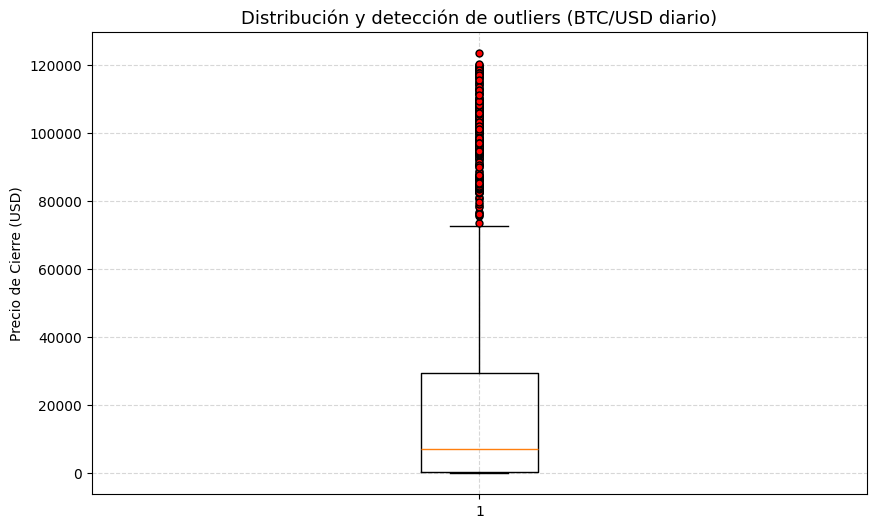

In [33]:
plt.figure(figsize=(10, 6))

plt.boxplot(
    btc_daily['Close'].dropna(),
    vert=True,
    showfliers=True,
    flierprops=dict(marker='o', markersize=5, markerfacecolor='red', markeredgecolor='black')
)

plt.title("Distribución y detección de outliers (BTC/USD diario)", fontsize=13)
plt.ylabel("Precio de Cierre (USD)")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

## Observar el comportamiento a lo largo del tiempo

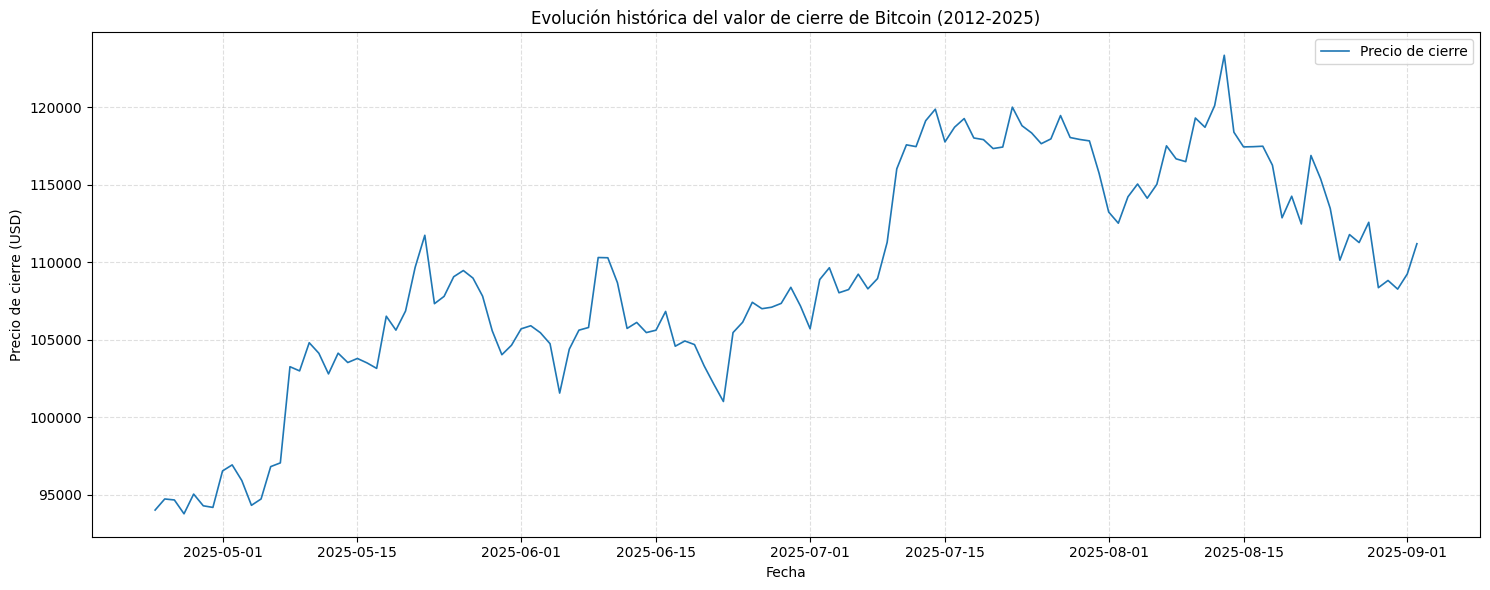

In [37]:
plt.figure(figsize=(15, 6))
plt.plot(
    df_daily.index,          # eje X → fechas (Timestamp)
    df_daily['Close'],       # eje Y → precios
    label="Precio de cierre",
    linewidth=1.2
)
plt.title("Evolución histórica del valor de cierre de Bitcoin (2012-2025)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


## Regresion Lineal Simple con la variable Close en base al tiempo transcurrido

C:\Users\AlexandreKz\AppData\Local\Temp\ipykernel_20288\3322355637.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


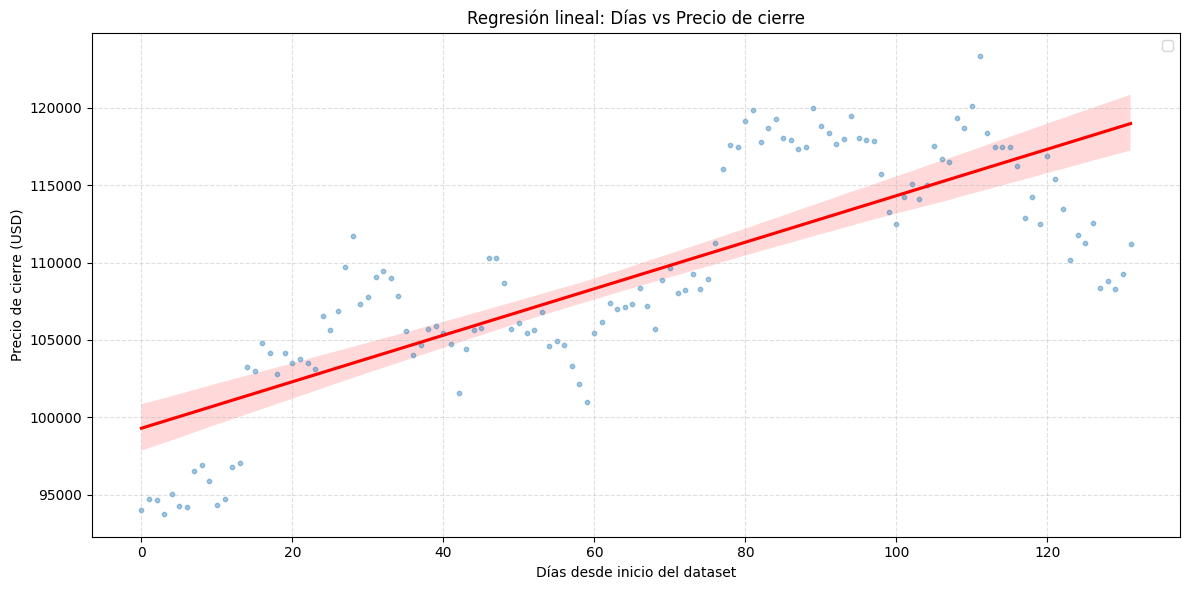

In [39]:
# Crear eje X como número de días desde el inicio
x_vals = np.arange(len(df_daily))
y_vals = df_daily['Close'].values  # precios en un array limpio

plt.figure(figsize=(12, 6))

# Línea de regresión
sns.regplot(
    x=x_vals,
    y=y_vals,
    scatter=False,
    color="red",
    line_kws={'label':"Tendencia lineal"}
)

# Scatter de puntos
plt.scatter(x_vals, y_vals, alpha=0.4, s=10)

plt.title("Regresión lineal: Días vs Precio de cierre")
plt.xlabel("Días desde inicio del dataset")
plt.ylabel("Precio de cierre (USD)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## Correlación de pearson

In [43]:
#Correlación de Pearson
mask = btc_daily[['t', 'Close']].dropna()

r, p = pearsonr(mask['t'], mask['Close'])

print(f'Correlación Pearson r = {r:.3f} | p-valor = {p:.3g}')

Correlación Pearson r = 0.795 | p-valor = 0


## Ver análisis estadístico

In [44]:
# Análisis estadístico descriptivo
descriptive_stats = btc_daily.describe()

print("Análisis estadístico descriptivo:")
print(descriptive_stats)

Análisis estadístico descriptivo:
                Open           High            Low          Close  \
count    4994.000000    4994.000000    4994.000000    4994.000000   
mean    19699.826904   20140.646468   19241.572791   19721.999994   
std     27801.080165   28323.941379   27254.809532   27829.727711   
min         4.380000       4.380000       3.800000       4.380000   
25%       434.347500     444.142500     425.557500     434.625000   
50%      6998.225000    7234.060000    6775.340000    7003.440000   
75%     29349.347500   29960.000000   28998.825000   29363.540000   
max    123360.000000  124517.000000  118972.000000  123360.000000   

              Volume            t  
count    4994.000000  4994.000000  
mean     7474.630219  2497.500000  
std      9048.831692  1441.787953  
min         0.000000     1.000000  
25%      1998.719014  1249.250000  
50%      4571.868227  2497.500000  
75%      9651.611067  3745.750000  
max    127286.486533  4994.000000  


### Solo variable Close

In [45]:
# Análisis estadístico descriptivo solo de la columna Close
descriptive_stats_close = btc_daily['Close'].describe()
print("Análisis estadístico descriptivo de Close:")
print(descriptive_stats_close)

Análisis estadístico descriptivo de Close:
count      4994.000000
mean      19721.999994
std       27829.727711
min           4.380000
25%         434.625000
50%        7003.440000
75%       29363.540000
max      123360.000000
Name: Close, dtype: float64


Aqui podemos observar varios datos relevantes principalmente el mean de close esde 19.721 USD, siendo el min y el max tan absurdamente distantes númericamente causa que la media se altere y hace que los datos esten muy dispersos. Se puede ver que la desviación estandar es de 27.829 lo que nos indica que la volatilidad de los datos es altisima y por ende los datos se encuentran muy dispersos.

## Ver distribución de valores

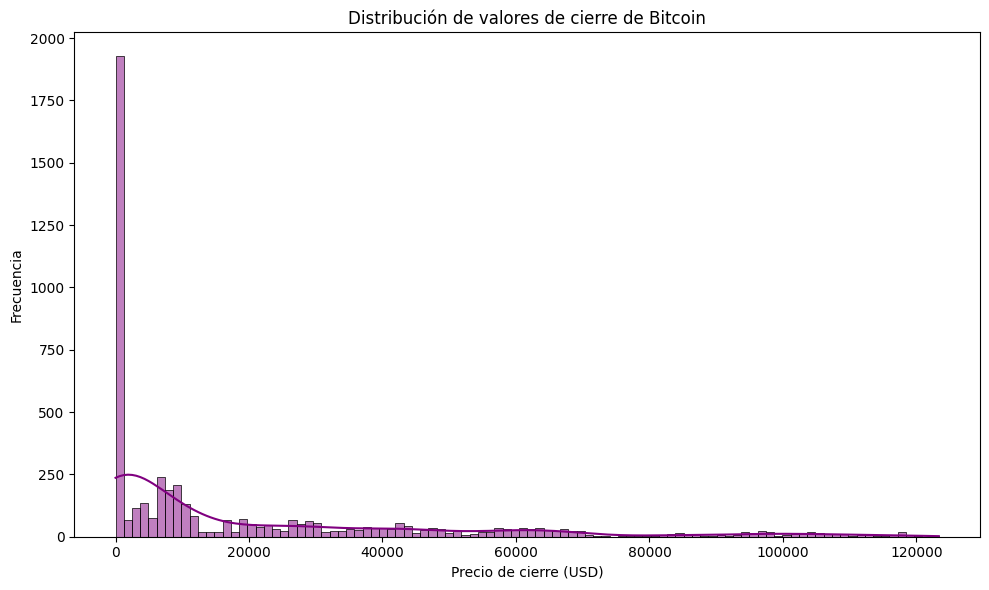

In [46]:
plt.figure(figsize=(10, 6))

sns.histplot(
    btc_daily['Close'].dropna(),
    bins=100,
    kde=True,
    color="purple"
)

plt.title("Distribución de valores de cierre de Bitcoin")
plt.xlabel("Precio de cierre (USD)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## Pruebas con modelos

### *MODELO HUBBER*

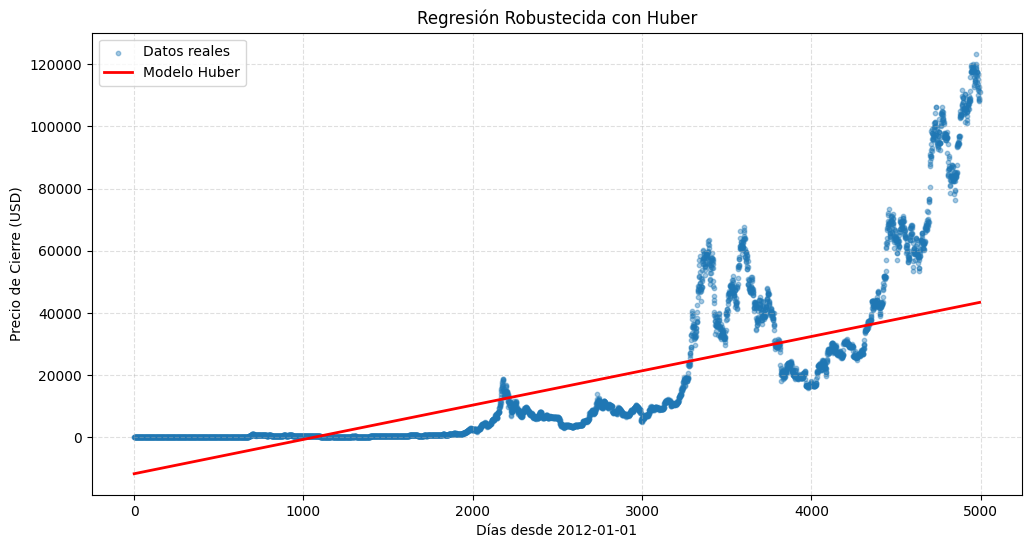

In [54]:
# Asegurar no tener NaN en t ni Close
df_clean = btc_daily[['t', 'Close']].dropna()

# Modelo de regresión robusta Huber
model = HuberRegressor()
model.fit(df_clean[['t']], df_clean['Close'])

# Predicciones
y_pred = model.predict(df_clean[['t']])

# Visualización
plt.figure(figsize=(12, 6))
plt.scatter(df_clean['t'], df_clean['Close'], s=10, alpha=0.4, label='Datos reales')
plt.plot(df_clean['t'], y_pred, color='red', linewidth=2, label='Modelo Huber')

plt.xlabel('Días desde 2012-01-01')
plt.ylabel('Precio de Cierre (USD)')
plt.title('Regresión Robustecida con Huber')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [55]:
# Predicciones del modelo Huber
y_huber_pred = model.predict(df_clean[['t']])

# Evaluación del modelo
r2 = r2_score(df_clean['Close'], y_huber_pred)
mae = mean_absolute_error(df_clean['Close'], y_huber_pred)
rmse = np.sqrt(mean_squared_error(df_clean['Close'], y_huber_pred))

print(f"Coeficiente de Determinación (R²): {r2:.4f}")
print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del MSE): {rmse:.2f}")

Coeficiente de Determinación (R²): 0.5630
MAE (Error Absoluto Medio): 12277.69
RMSE (Raíz del MSE): 18395.00


### *MODELO LINEAR REGRESSION*

Coeficiente de regresión (pendiente): 15.348239927699632
Intercepto: -18610.229225437037


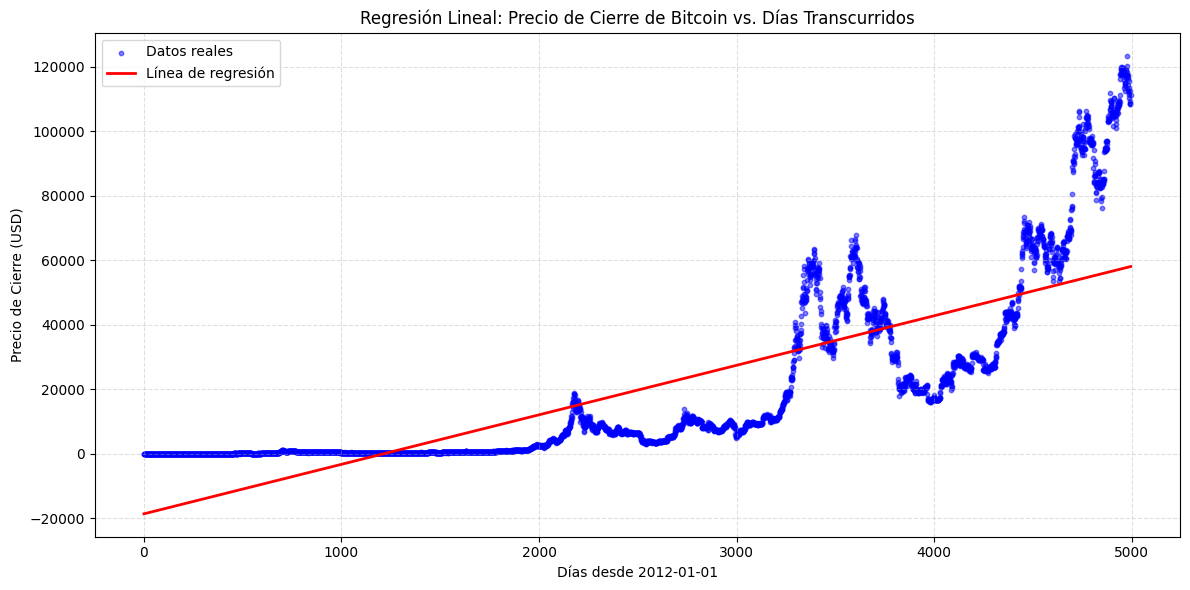

In [50]:
# Variable independiente (t) y dependiente (Close)
X = btc_daily[['t']]        # Número de días transcurridos
y = btc_daily['Close']      # Precio de cierre

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predicciones
y_pred = model.predict(X)

# Resultados
print("Coeficiente de regresión (pendiente):", model.coef_[0])
print("Intercepto:", model.intercept_)

# Graficar
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', alpha=0.5, s=10, label='Datos reales')
plt.plot(X, y_pred, color='red', linewidth=2, label='Línea de regresión')

plt.title("Regresión Lineal: Precio de Cierre de Bitcoin vs. Días Transcurridos")
plt.xlabel("Días desde 2012-01-01")
plt.ylabel("Precio de Cierre (USD)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [51]:
# Evaluación del modelo
mae = mean_absolute_error(y, y_pred)          # Error absoluto medio
rmse = np.sqrt(mean_squared_error(y, y_pred)) # Raíz del MSE
r2 = r2_score(y, y_pred)                       # Coeficiente de determinación

print(f"MAE (Error absoluto medio): {mae:.2f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.2f}")
print(f"R² (Coeficiente de determinación): {r2:.4f}")

MAE (Error absoluto medio): 13298.78
RMSE (Raíz del error cuadrático medio): 16874.48
R² (Coeficiente de determinación): 0.6323


# Conclusion

### Al aplicar tanto la regresión lineal ordinaria como la regresión robusta Huber sobre el valor de cierre diario de Bitcoin utilizando el tiempo (en días) como variable explicativa, se observa que ambos modelos identifican una tendencia ascendente general, lo cual podría sugerir una relación positiva entre el tiempo y el precio. Sin embargo, cuando se evalúa la capacidad explicativa real de los modelos, los resultados muestran que esta relación es débil y no significativa en términos predictivos.

### De momento no se puede ni validar ni rechazar la hipótesis, ya que los datos utilizados para entrenamiento de modelos no se encuentran debidamente tratados y se requiere escalar outliers. 